In [1]:
# import pprint
# import sys

# pprint.pprint(sys.path)

In [2]:
# import fundamental libraries
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import os
import sys
sys.path.append('/mnt/c/Users/44yos/RacePrediction/resnet_win5')
from os import path
import time

# preporcessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from pickle import dump

# tesndorflow libraries
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import optimizers, callbacks
from tensorflow.python.keras import backend as K

# from models import resnet
from models import transformer

# from utils import functions
from utils import create_time_series_data, smooth_label, categorical_focal_loss, order_algorithm

In [3]:
# # load data
# data = pd.read_csv("../data/csv/data.csv", sep = ",")
# print(data.dtypes)

In [4]:
# data.dropna(inplace=True)
# print(len(data))

In [5]:
# data.drop_duplicates(inplace=True)
# print(len(data))

In [6]:
# # adjust columns type
# data['race_id'] = data['race_id'].astype(str)
# data['order'] = data['order'].astype(str)

In [7]:
# # delete race day information
# data.drop(["horse_number", "half_order", "goal_time" ,"last_time", "horse_weight", "horse_weight_dif", "frame_number","pop"], axis = 1, inplace=True)
# # "race_round",
# data.reset_index(drop=True, inplace=True)

In [9]:
# print(data.dtypes)

In [10]:
# # standarlization 
# no_scale_data = data[['race_id','order']]
# scale_columns = data.drop(['race_id','order'], axis=1).columns.values
# standard_scale = StandardScaler()
# data = pd.DataFrame(standard_scale.fit_transform(data[scale_columns]))

# # PCA
# pca = PCA()
# data = pd.DataFrame(pca.fit_transform(data))
# contrb_rate = pd.DataFrame(pca.explained_variance_ratio_, columns = ['rate'])
# sum_rate = 0

# #  # to get the colum of the specific contribution rate
# # for i in range(len(contrb_rate)):
# #     sum_rate += contrb_rate.rate[i]
# #     if sum_rate >= 0.9:
# #         max_col = i + 1
# #         break

max_col = 84
# # print(max_col)
# data = data.loc[:, :max_col-1]
# print(data.shape[1])
# # print(data.head(5))
# # print(len(data), len(no_scale_data))
# # print(no_scale_data[no_scale_data['race_id'].isnull()])
# data = pd.concat([data, no_scale_data], axis=1)
# dump(standard_scale, open("standard_scale.pkl", "wb"))
# dump(pca, open("pca.pkl", "wb"))

In [11]:
# print(sorted(no_scale_data['order'].unique()))

In [12]:
# print(data.shape)
# print(data.dtypes)
# print(data.head(20))

In [13]:
# def create_time_series_data(raw_data):
#     number_of_race = raw_data.race_id.nunique()
#     time_series_data = np.full((number_of_race, 24, max_col), 0.0)#-float('inf')
#     label = np.full((number_of_race, 24), 25)
#     race_number = 0
#     horse_number = 0
#     for i in range(len(raw_data)):
#         if i == 0:
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#             continue
#         # add new race
#         if data.iloc[i].race_id != data.iloc[i-1].race_id:
#             race_number += 1
#             horse_number = 0
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#         # add new horse to the same race
#         else:
# #             print(data.iloc[i].race_id ,race_number, horse_number)
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#     del raw_data
#     return time_series_data, label

In [14]:
# X, y_order = create_time_series_data(data)
# np.save('X', X)
# np.save('y_order', y_order)
X = np.load('X.npy')
y_order = np.load('y_order.npy')
# del data
print(X.shape)
print(y_order.shape)

(20132, 24, 84)
(20132, 24)


In [16]:
# print(X[0])

In [17]:
X = X.astype('float32')
print(X.dtype)

float32


In [18]:
print(X[0][11])
print(y_order[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 7 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [19]:
alpha = len(y_order) / pd.DataFrame(y_order.flatten()).value_counts()
alpha = alpha.sort_index()
alpha = np.array(alpha)
alpha = np.append(0,alpha)
print(alpha.shape)
print(alpha)

(26,)
[0.00000000e+00 1.21687621e+00 1.21555368e+00 1.23063757e+00
 1.24041898e+00 1.25990362e+00 1.26100846e+00 1.28155834e+00
 1.32325490e+00 1.37157651e+00 1.45736210e+00 1.56413643e+00
 1.73521807e+00 1.98052140e+00 2.27608819e+00 2.71833648e+00
 3.58156912e+00 1.49347181e+01 2.00918164e+01 1.25825000e+03
 1.43800000e+03 2.51650000e+03 3.35533333e+03 4.02640000e+03
 5.03300000e+03 7.53440294e-02]


In [20]:
# creating X,y (parameters and target)
y = np_utils.to_categorical(y_order, dtype='float32')
print(y[5])
print(y.shape)
print(X.shape)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0.

In [21]:
# def smooth_label(label, factor=0.03):
#     # smooth label
#     label *= (1 - factor)
# #     label[:,:,1:4] += (factor / 3)

#     for i in range(label.shape[0]):
#         for j in range(label.shape[1]):
#             t = np.where(label[i][j] == 1 - factor)
#             label[i,j,max(0,t[0][0]-1):min(26,t[0][0]+2)] += (factor / 3)
#     return label

In [22]:
y = smooth_label(y) 
print(y[4])
print(y.shape)
print(X.shape)

[[0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

In [23]:
# print(data.race_id.value_counts().plot.hist(bins=25,range=(1,25)))

AxesSubplot(0.125,0.125;0.775x0.755)


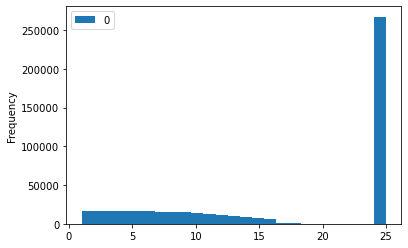

In [24]:
print(pd.DataFrame(y_order.flatten()).plot.hist(bins=25))## ,ylim=(0,1000)

In [25]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.01, random_state = 0)
del X, y

In [26]:
print(X_train[0][1])

[-5.0841513e+00  7.0771635e-02 -5.8418870e-01  2.4646287e-01
  1.8285137e+00 -1.1262701e+00  6.5735537e-01  1.5329328e+00
  6.2066919e-01 -6.7069030e-01  1.0873965e+00  1.7795300e-01
 -2.2035263e+00 -5.5455178e-01  1.5312845e+00  1.9849390e+00
 -1.9881687e+00 -4.5285341e-01 -1.1557992e+00  3.0845302e-01
  6.5695131e-01 -1.6801572e+00  1.2509111e-01 -6.3480353e-01
  2.6424465e-01 -1.8350914e+00  1.3959821e+00 -1.1001785e+00
 -2.4194989e+00  2.9623857e+00  1.4317343e+00  1.9310854e-02
  3.4215423e-01  7.4966168e-01 -1.0088371e+00  8.0969352e-01
 -2.5986239e-01 -8.4669787e-01  1.0779321e+00  6.1363038e-02
 -1.5148355e+00 -1.8475902e-03 -8.8226789e-01 -6.8742210e-01
 -2.6793274e-01  1.6574528e+00 -2.0822718e+00 -1.7538213e+00
  4.2922177e+00  1.6022534e+00 -4.4454589e-01 -6.7625672e-01
 -8.8914499e-02 -1.1668312e-01 -3.3394665e-01 -7.5860035e-01
  3.7061727e-01 -6.4284933e-01  3.2509527e-01  4.8748016e-01
  1.5954223e+00  1.4406800e-01 -8.7014019e-01  6.6753399e-01
 -1.0578674e+00  4.23975

In [27]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(19930, 24, 84)
(202, 24, 84)
(19930, 24, 26)
(202, 24, 26)


In [28]:
# def categorical_focal_loss(alpha, gamma):
#     """
#     Softmax version of focal loss.
#     When there is a skew between different categories/labels in your data set, you can try to apply this function as a
#     loss.
#            m
#       FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
#           c=1
#       where m = number of classes, c = class and o = observation
#     Parameters:
#       alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
#       categories/labels, the size of the array needs to be consistent with the number of classes.
#       gamma -- focusing parameter for modulating factor (1-p)
#     Default value:
#       gamma -- 2.0 as mentioned in the paper
#       alpha -- 0.25 as mentioned in the paper
#     References:
#         Official paper: https://arxiv.org/pdf/1708.02002.pdf
#         https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
#     Usage:
#      model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
#     """

#     alpha = np.array(alpha, dtype=np.float32)

#     def categorical_focal_loss_fixed(y_true, y_pred):
#         """
#         :param y_true: A tensor of the same shape as `y_pred`
#         :param y_pred: A tensor resulting from a softmax
#         :return: Output tensor.
#         """

#         # Clip the prediction value to prevent NaN's and Inf's
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

#         # Calculate Cross Entropy
#         cross_entropy = -y_true * K.log(y_pred)

#         # Calculate Focal Loss
#         loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

#         # Compute mean loss in mini_batch
#         return K.mean(K.sum(loss, axis=-1))

#     return categorical_focal_loss_fixed

In [29]:
# creating dataset with batch size
batch_size = 2048 # hyperparameter
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=19930).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size=202).batch(batch_size)


del X_train, y_train

In [44]:
# set up parameters
num_layers = 1 # hyperparameter
d_model = max_col # 4*35 84=4*3*7
num_heads = 28 # hyperparameter *must be a factor of d_model*
d_ffn = 256 # hyperparameter
pe_input = 24
target_size = 26
dropout_rate = 0.1 # hyperparameter

In [45]:
# set up model
trans_race = transformer.TransRace(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ffn=d_ffn,
    pe_input=pe_input,
    target_size=target_size,
    rate=dropout_rate,
)
opt = optimizers.Adam(decay=0.01)
loss = categorical_focal_loss(alpha=[alpha], gamma=0.5)

In [106]:
trans_race.compile(
    optimizer=opt,
    loss=loss,#'categorical_crossentropy', # 'sigmoid_focal_crossentropy'
    metrics=['accuracy'], #['categorical_accuracy']
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='../models/results/transformer.h5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
)

history = trans_race.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    verbose=True, # hide the output because we have so many epochs
    callbacks=[model_checkpoint_callback]
)
print(trans_race.summary())
# trans_race.save_weights("../models/results/transformer.h5")

Train on 10 steps, validate on 1 steps
Epoch 1/50
10/10 [==============================] - 3s 312ms/step - loss: 2.5423 - acc: 0.4544 - val_loss: 2.5275 - val_acc: 0.5043
Epoch 2/50
10/10 [==============================] - 1s 129ms/step - loss: 2.5220 - acc: 0.4895 - val_loss: 2.5545 - val_acc: 0.5235
Epoch 3/50
10/10 [==============================] - 1s 130ms/step - loss: 2.4506 - acc: 0.5054 - val_loss: 2.6064 - val_acc: 0.5307
Epoch 4/50
10/10 [==============================] - 1s 127ms/step - loss: 2.3968 - acc: 0.5187 - val_loss: 2.3817 - val_acc: 0.5425
Epoch 5/50
10/10 [==============================] - 1s 129ms/step - loss: 2.3372 - acc: 0.5275 - val_loss: 2.3571 - val_acc: 0.5466
Epoch 6/50
10/10 [==============================] - 1s 128ms/step - loss: 2.3394 - acc: 0.5340 - val_loss: 2.3481 - val_acc: 0.5487
Epoch 7/50
10/10 [==============================] - 1s 128ms/step - loss: 2.3283 - acc: 0.5383 - val_loss: 2.2995 - val_acc: 0.5505
Epoch 8/50
10/10 [===================

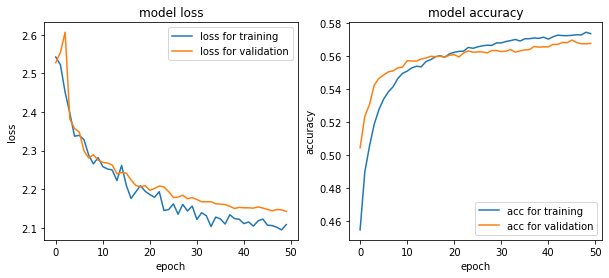

In [107]:
# plot 
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# for loss
axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
axR.plot(history.history['acc'],label="acc for training")
axR.plot(history.history['val_acc'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='lower right')
# figureの保存
# plt.savefig("../models/results/trans_race_result.png")

In [116]:
# predict

preds = trans_race.predict(X_valid)
y_pred = np.argmax(preds, axis = 2)
y_ans = np.argmax(y_valid, axis = 2)


In [117]:
# def order_algorithm(preds):
#     num_race = preds.shape[0]
#     y_preds = np.full((num_race, 24), 25)
#     for i in range(num_race):
#         one_race = preds[i,:,:]
#         init_preds = np.argmax(one_race, axis = -1)
#         exist_horse = np.delete(one_race, np.where(init_preds == 25)[0], 0)
#         for j in range(1,exist_horse.shape[0]+1):
#             one_order = np.argmax(exist_horse[:,j])
#             for k in range(one_race.shape[0]):
#                 if np.array_equal(one_race[k], exist_horse[one_order]):
#                     y_preds[i][k] = j
#                     exist_horse = np.delete(exist_horse, one_order, 0)
#                     break
#     return y_preds

In [118]:
# print(pd.DataFrame(preds[0]))

In [119]:
# def order_algorithm(preds):
#     num_race = preds.shape[0]
#     y_preds = np.full((num_race, 24), 25)
#     for i in range(num_race): # iterate all race
#         one_race = preds[i,:,:] # shape = (24, 26) ,so (num of horse, num of target 0-25)
#         init_preds = np.argmax(one_race, axis = -1)
#         exist_horse = np.delete(one_race, np.where(init_preds == 25)[0], 0) # shape = (num of exist horse, 26)
#         for j in range(1,exist_horse.shape[0]+1): # iterate 1-num of exist horse
#             one_order = np.argmax(exist_horse[:,j]) # this is a target order
#             for k in range(one_race.shape[0]): # search the horse k = (0, 23)
#                 if np.array_equal(one_race[k], exist_horse[one_order]):
#                     y_preds[i][k] = j
#                     exist_horse = np.delete(exist_horse, one_order, 0)
#                     exist_horse[:,j+1] += exist_horse[:,j]
#                     one_race[:,j+1] += one_race[:,j]
#                     break
#     return y_preds

In [120]:
y_preds = order_algorithm(preds)
print(y_preds.shape)
print(y_preds[0])

(202, 24)
[ 4  2  5  6  1  3 10  9  7  8 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [122]:
print(preds.shape)
print(y_preds.shape)
print(y_ans.shape)


In [123]:
print(y_ans[0])
print(y_preds[0])
print(y_pred[0])
# print(np.mean(y_pred))

[11  4  5 12  8  1  2  9  6 10 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
[ 4  2  5  6  1  3 10  9  7  8 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
[ 4  2  5  8  1  3  6  9  7 10 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
[ 1  2  1  8  1  1  3 10  5  8 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [124]:
correct = 0
for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        if (y_preds[i][j] == y_ans[i][j]):
            correct += 1
accuracy = correct / len(y_pred)
print("accuracy: ", accuracy)

accuracy:  13.767326732673267


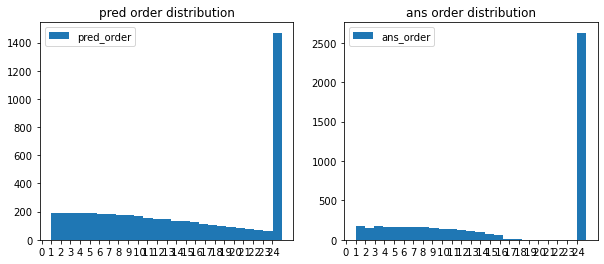

In [105]:
# the distribution of prediction
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
label = ['0','1','2','3','4','5','6','7','8','9',' 10',' 11',' 12',' 13',' 14',' 15',' 16',' 17',' 18',' 19',' 20',' 21',' 22',' 23',' 24']

axL.hist(y_preds.flatten(), bins = 25, label = "pred_order")##, range = (1,21)
axL.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
axL.set_xticklabels(label)
axL.set_title('pred order distribution')
axL.legend()
axR.hist(y_ans.flatten(), bins = 25, label = "ans_order")##, range = (1,21)
axR.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
axR.set_xticklabels(label)
axR.set_title('ans order distribution')
axR.legend()
fig.show()


In [34]:
# precision = TP / (TP + FP)
# the accuracy of predected True
i = 0
correct_first = 0
all_f = 0
increase = 0
X_valid_inv = standard_scale.inverse_transform(X_valid)
X_valid_inv_df = pd.DataFrame(X_valid_inv)
odds = X_test_inv_df['odds'].values
hit_odds = []
select = []

for i in range(len(Y_ans)):
    if (pred_order[i] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
        all_f = all_f + 1
        if (Y_ans[i] == 1):
            correct_first = correct_first + 1   #　True Positive
            increase += odds[i]
            hit_odds.append(odds[i])
            
            
            
print("all_f: ", all_f)
print("correct_first: ", correct_first)
print("hit odds average: ", np.array(hit_odds).mean())
print("spent money:", all_f * 100)
revenue = (increase - all_f) * 100
retrive = increase / all_f
 
print("retrive rate: ", retrive) 
print("revenue: ", revenue)
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
#print("\n".join(map(str,hit_odds)))
print("min: ", min(hit_odds))
print("mid: ", np.median(np.array(hit_odds)))
print("max: ", max(hit_odds))

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.hist(hit_odds, bins = 50, label = "hit_odds")
axL.set_title('hit odds distribution')
axL.legend()
axR.hist(odds, bins = 50, label = "odds", range = (0,40))
axR.set_title('all odds distribution')
axR.legend()
fig.show()


ValueError: operands could not be broadcast together with shapes (202,24,84) (140,) (202,24,84) 

In [ ]:
# Recall = TP / (TP + FN)
# the accuracy of label True
i = 0
correct_first = 0
all_f = 0
odds_f = []
p_rate_f = []

all_f_odds = []

for i in range(len(Y_ans)):
    if (Y_ans[i] == 1):  # TP + FN
        all_f = all_f + 1
        all_f_odds.append(odds[i])
        if (pred_order[i] == 1):
            correct_first = correct_first + 1   #　TP
            odds_f.append(odds[i])
            p_rate_f.append(pred[i][1])

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.scatter(p_rate_f, odds_f)  
axL.set_title('correlation odss and prediction')
#axL.xlabel('prediction rate first')
#axL.ylabel('odds')
axR.hist(odds_f, bins = 50, label = "odds")
axR.set_title('all first odds distribution')
axR.legend()

fig.show()
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
print("all_f_odds average: ", np.array(all_f_odds).mean())

